## Importing Libraries

In [60]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Keypoints

In [61]:
mp_holistic = mp.solutions.holistic # gets keypoints
mp_drawing = mp.solutions.drawing_utils # shows/draws keypoints

In [62]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                 
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [63]:
def draw_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

In [64]:
# To test keypoints
# cap = cv2.VideoCapture(0)
# # Set model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read frames
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
#         # Draw keypoints
#         draw_landmarks(image, results)

#         # Show to screen
#         cv2.imshow('OpenCV Feed', image)

#         # Quit if Q is pressed
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

## Extracting Keypoint values

In [65]:
#taking location of keypoints and mapping them in a numpy array
def extract_keypoints(results):
    #pose
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    #left hand
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    #right hand
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) # returns concatenated list of all keypoints

## Setting up folders for collection

In [66]:
DATA_PATH = os.path.join('MP_Data') # Create root folder
actions = np.array(['Hello','Home','Thanks','Perfect']) 
no_sequences = 30 #30 videos
sequence_length = 30 #30 frames

In [106]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence))) #create folder and sub-folders
        except:
            pass #if already exists

## Collect data for training and testing

In [67]:
cap = cv2.VideoCapture(0)
# Set model for keypoint detection
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through videos
        for sequence in range(no_sequences):
            # Loop through video length
            for frame_num in range(sequence_length):

                # Read frame
                ret, frame = cap.read()

                # Make keypoint detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks/keypoints
                draw_landmarks(image, results)
                
                # wait logic with Text appearing over to indicate
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(3500) #interval for each video
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

## Preprocessing Data

In [68]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [69]:
label_map = {label:num for num, label in enumerate(actions)}

In [70]:
label_map

{'Hello': 0, 'Home': 1, 'Thanks': 2, 'Perfect': 3}

In [71]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = [] #each frame will be here
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))#get frame
            window.append(res)#append frame
        sequences.append(window)#append set of frames/videos to sequence
        labels.append(label_map[action])

In [72]:
np.array(sequences).shape #150 videos, 30 frames each, with 1662 keypoints

(120, 30, 1662)

In [73]:
X = np.array(sequences)

In [74]:
X.shape

(120, 30, 1662)

In [75]:
y = to_categorical(labels).astype(int)

In [76]:
# y #['Hello','Home','Thanks','Perfect']

In [77]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

## Creating model (LSTM)

- Less Data required to train 
- Faster to train
- Faster detections

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [79]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [80]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) # 30 frames, 1662 keypoints x.shape[1],[2]
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) # 5 actions

In [81]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

In [82]:
# model.fit(x_train, y_train, epochs = 300, callbacks = [tb_callback])

In [83]:
model.load_weights('sign.h5')

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-tr

In [85]:
res = model.predict(x_test)

1/1 [==============================] - 0s 308ms/step


In [86]:
actions[np.argmax(res[0])] #predicted

'Home'

In [87]:
actions[np.argmax(y_test[0])] #actual

'Home'

## Save Model

In [88]:
# model.save('sign.h5')

In [89]:
# load weights
# model.load_weights('sign.h5') #do this after compiling and building model

## Evaluate model

In [90]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [91]:
yhat = model.predict(x_test)
yhat

1/1 [==============================] - 0s 55ms/step


array([[7.9811269e-09, 9.4878083e-01, 9.5807969e-05, 5.1123369e-02],
       [9.4618773e-01, 1.7345864e-03, 4.2435765e-02, 9.6419230e-03],
       [8.4162742e-02, 4.5587709e-03, 7.6247406e-01, 1.4880438e-01],
       [9.6386611e-01, 8.5540715e-04, 2.9584667e-02, 5.6937807e-03],
       [2.9754681e-05, 1.9282009e-02, 3.2497573e-01, 6.5571243e-01],
       [2.2897666e-07, 7.6787573e-01, 2.1460741e-03, 2.2997797e-01]],
      dtype=float32)

In [92]:
ytrue = np.argmax(y_test,axis = 1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()

In [93]:
 accuracy_score(ytrue, yhat)

1.0

## Test

In [106]:
colors = [(245,117,16), (117,245,16), (16,117,245),(0,255,255),(204,0,102) ]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

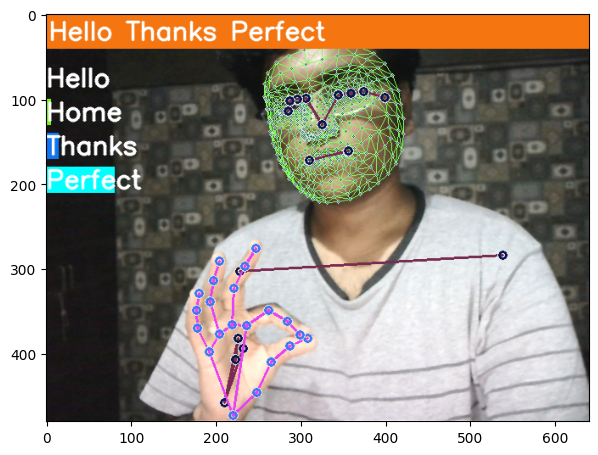

In [109]:
plt.figure(figsize=(7,7))
plt.imshow(prob_viz(res, actions, image, colors))

In [100]:
sequence = []
sentence = []
threshold = 0.4

cap = cv2.VideoCapture(0)
# Set model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read frames
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw keypoints
        draw_landmarks(image, results)

        #prediction
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
         
        if len(sequence)==30:
            res = model.predict(np.expand_dims(sequence,axis=0))[0]
#             print(res)
        
        #Visualization
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 3: 
                sentence = sentence[-3:]
            
            image = prob_viz(res, actions, image, colors)
            
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Quit if Q is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
